In [4]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels

In [5]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'       
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

In [6]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,pr.Description AS province , di.Description AS district 
, ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [7]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [8]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,CSO008001526,56,2018-11-07 08:00:46.443,374,J.S PHARMACY,North Western Province,Puttalam,CHILAW,80,Sithum Asela,2,The West Central Pharma (Pvt) Ltd.,234,Nicardia-XL-30mg 30's,1.0,705.25,804.0,0.0,0.0,705.25,2018,November,11,7,4,Wednesday,8
1,CSO008001526,56,2018-11-07 08:00:46.443,374,J.S PHARMACY,North Western Province,Puttalam,CHILAW,80,Sithum Asela,2,The West Central Pharma (Pvt) Ltd.,238,Dicloran Gel 20gm,3.0,170.60,194.5,0.0,0.0,511.80,2018,November,11,7,4,Wednesday,8
2,CSO008001568,56,2018-11-10 10:28:06.550,3302,New Lanka Pharmacy,Western Province,Gampaha,Negombo,80,Sithum Asela,2,The West Central Pharma (Pvt) Ltd.,234,Nicardia-XL-30mg 30's,100.0,705.25,804.0,0.0,0.0,70525.00,2018,November,11,10,7,Saturday,10
3,CSO008001568,56,2018-11-10 10:28:06.550,3302,New Lanka Pharmacy,Western Province,Gampaha,Negombo,80,Sithum Asela,2,The West Central Pharma (Pvt) Ltd.,245,Diatica Tab 80mg 100's,50.0,1040.80,1186.5,0.0,0.0,52040.00,2018,November,11,10,7,Saturday,10
4,CSO009300431,106,2018-11-10 10:51:25.857,4391,Dr. Kamaladasa,Western Province,Colombo,Maharagama,93,Chandana Gunawardena,9,Multy Drugs (Pvt) Ltd,2,Cosvate GM Cream 15gm,10.0,258.75,295.0,0.0,0.0,2587.50,2018,November,11,10,7,Saturday,10


### Select the most selling product to identify the time series prediction

In [10]:
# select product sales records 
#Belcid Suspension 240ml top 1 product - based on unit qty
Pro1_invoice_All = invoice_All.loc[invoice_All['ItemUID'] == 25]

In [11]:
Pro1_invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
151,CSO009400373,107,2018-11-10 10:40:06.473,970,Santadoora Hospital,Western Province,Colombo,Battaramulla,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,10.0,238.7,272.0,0.0,0.0,2387.0,2018,November,11,10,7,Saturday,10
152,CSO009400373,107,2018-11-10 10:40:06.473,970,Santadoora Hospital,Western Province,Colombo,Battaramulla,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,0.0,238.7,272.0,3.0,3.0,0.0,2018,November,11,10,7,Saturday,10
380,CSO009400371,107,2018-11-10 10:41:16.243,972,Pelawatta Pharmacy,Western Province,Colombo,Palawatta,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,10.0,238.7,272.0,0.0,0.0,2387.0,2018,November,11,10,7,Saturday,10
393,CSO009201199,110,2018-11-02 16:46:42.260,1712,Saranga Pharmacy,Southern Province,Galle,Hikkaduwa,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,2,6,Friday,16
394,CSO009201199,110,2018-11-02 16:46:42.260,1712,Saranga Pharmacy,Southern Province,Galle,Hikkaduwa,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,0.0,216.7,247.0,2.0,3.0,0.0,2018,November,11,2,6,Friday,16


In [12]:
 #get date from date time
Pro1_invoice_All['just_date'] = Pro1_invoice_All['Date'].dt.date

<ipython-input-12-dd577f3fd3f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pro1_invoice_All['just_date'] = Pro1_invoice_All['Date'].dt.date


In [13]:
Pro1_inv_grp = Pro1_invoice_All.groupby("just_date").agg({'UnitQty':'sum'}).reset_index()

In [14]:
Pro1_inv_grp 

,just_date,UnitQty
0,2018-11-01,123.0
1,2018-11-02,90.0
2,2018-11-03,84.0
3,2018-11-04,10.0
4,2018-11-05,215.0
...,...,...
435,2020-02-25,2127.0
436,2020-02-26,1385.0
437,2020-02-27,919.0
438,2020-02-28,896.0


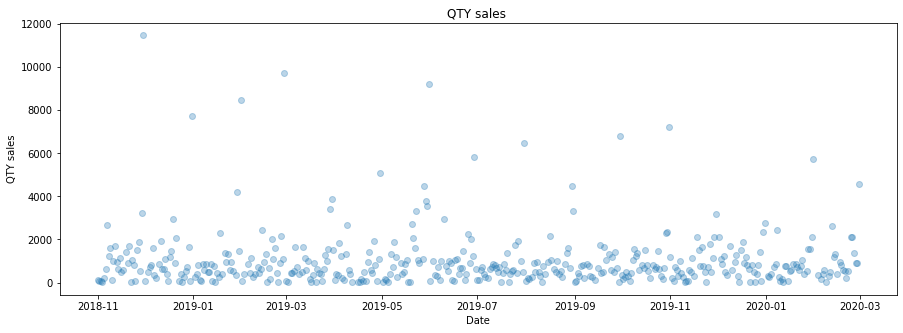

In [17]:
plt.scatter(Pro1_inv_grp.just_date , Pro1_inv_grp.UnitQty , alpha=0.3,cmap='viridis')
plt.xlabel("Date")
plt.ylabel("QTY sales")
plt.title("QTY sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

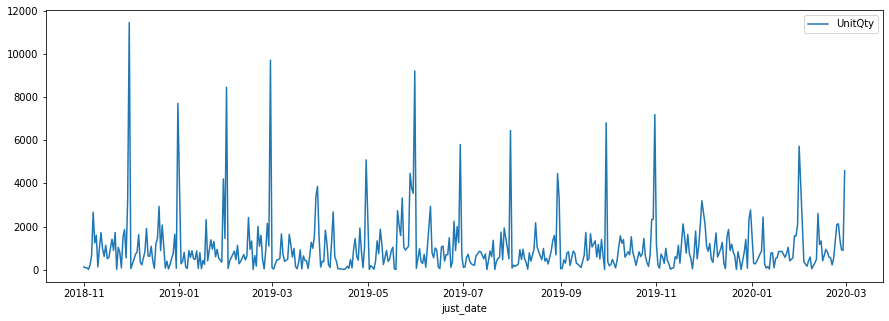

In [18]:
Pro1_inv_grp.plot(kind = 'line', x = 'just_date', y = 'UnitQty')
plt.show()

In [20]:
# remove z score > 3 
Pro1_inv_grp = Pro1_inv_grp[(np.abs(stats.zscore(Pro1_inv_grp["UnitQty"])) < 3)]

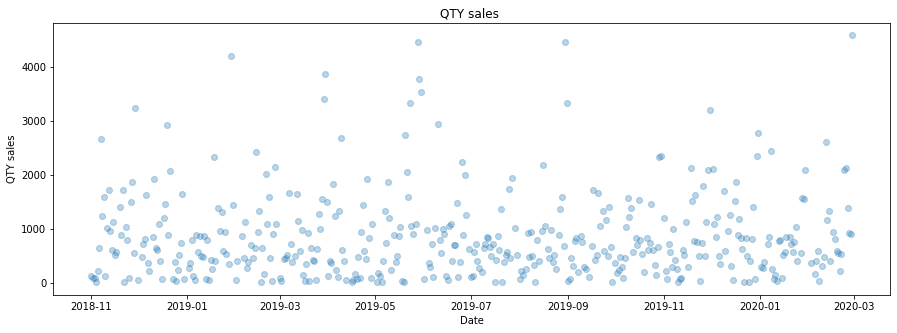

In [22]:
plt.scatter(Pro1_inv_grp.just_date , Pro1_inv_grp.UnitQty , alpha=0.3,cmap='viridis')
plt.xlabel("Date")
plt.ylabel("QTY sales")
plt.title("QTY sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

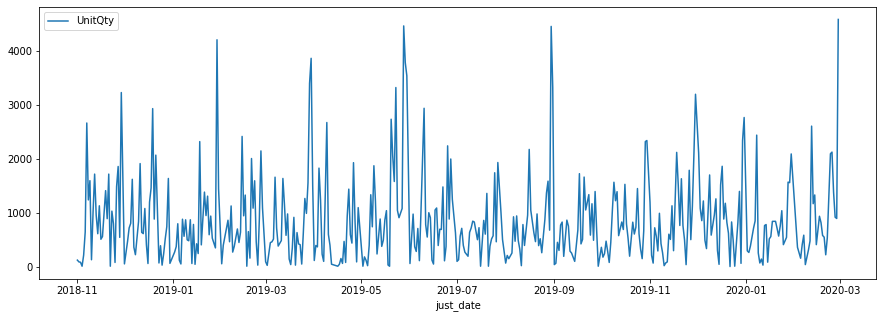

In [23]:
Pro1_inv_grp.plot(kind = 'line', x = 'just_date', y = 'UnitQty')
plt.show()

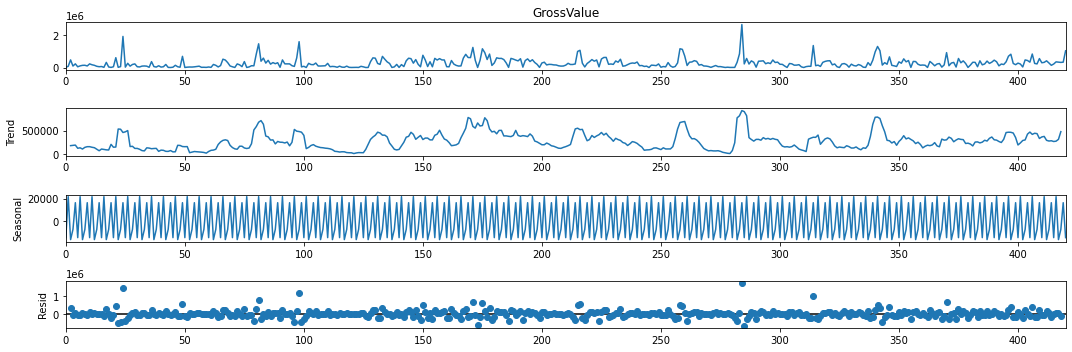

In [15]:
decomposition = seasonal_decompose(Pro1_inv_grp['GrossValue'], period =5)
decomposition.plot()
plt.show()

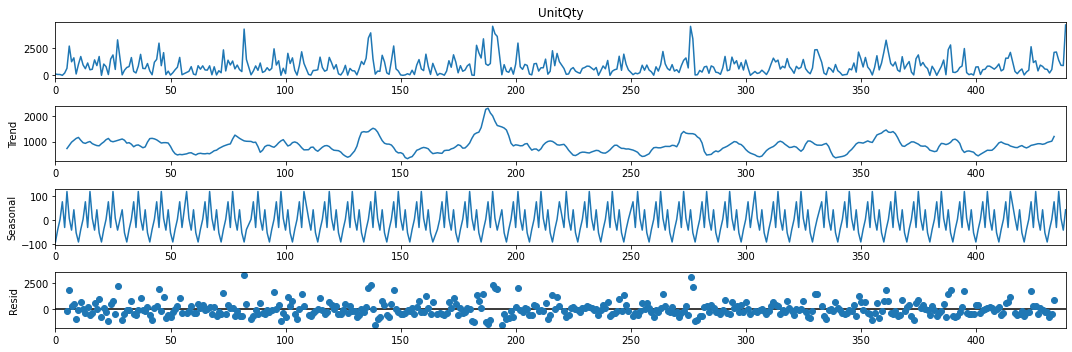

In [24]:
decomposition = seasonal_decompose(Pro1_inv_grp['UnitQty'], period =10)
decomposition.plot()
plt.show()

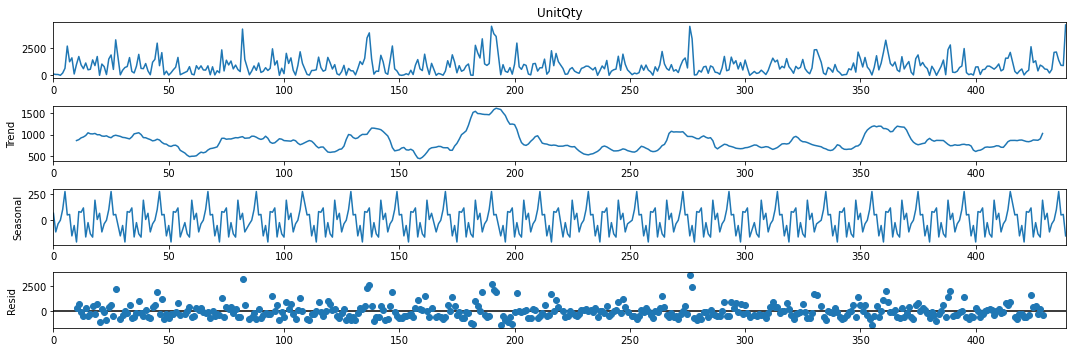

In [25]:
decomposition = seasonal_decompose(Pro1_inv_grp['UnitQty'], period =20)
decomposition.plot()
plt.show()

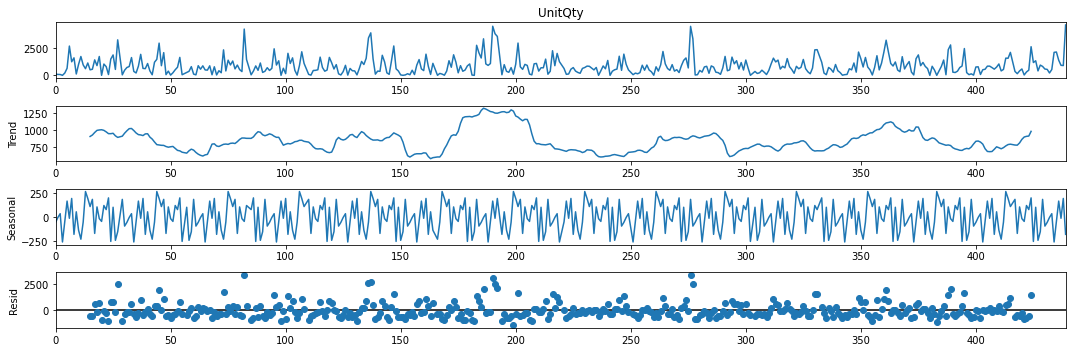

In [26]:
decomposition = seasonal_decompose(Pro1_inv_grp['UnitQty'], period =30)
decomposition.plot()
plt.show()

In [27]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(Pro1_inv_grp['UnitQty'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -1.478810e+01
p-value                        2.192601e-27
#Lags Used                     0.000000e+00
Number of Observations Used    4.280000e+02
Critical Value (1%)           -3.445721e+00
Critical Value (5%)           -2.868317e+00
Critical Value (10%)          -2.570380e+00
dtype: float64


In [28]:
 #fill in the missing dates
drange = pd.date_range(start=Pro1_inv_grp.just_date.min(), end=Pro1_inv_grp.just_date.max())
Pro1_inv_grp = Pro1_inv_grp.set_index('just_date').reindex(drange).rename_axis('just_date').reset_index()

In [29]:
#fill missing value with mean
Pro1_inv_grp.fillna({"UnitQty":Pro1_inv_grp['UnitQty'].mean().round(1)}, inplace=True)

In [30]:
Pro1_inv_grp = Pro1_inv_grp.sort_index()
Pro1_inv_grp.head(50)

,just_date,UnitQty
0,2018-11-01,123.0
1,2018-11-02,90.0
2,2018-11-03,84.0
3,2018-11-04,10.0
4,2018-11-05,215.0
5,2018-11-06,646.0
6,2018-11-07,2667.0
7,2018-11-08,1240.0
8,2018-11-09,1597.0
9,2018-11-10,130.0


In [31]:
#Pro1_inv_Nor_Sm = Pro1_inv_Nor_Sm.reset_index()
train = Pro1_inv_grp.loc[Pro1_inv_grp['just_date'] <= "2019-11-30"]
train = train.set_index('just_date')
test = Pro1_inv_grp.loc[Pro1_inv_grp['just_date'] > "2019-11-30"]
test = test.set_index('just_date')

In [33]:
from pmdarima import auto_arima
model = auto_arima(train.UnitQty, test='adf', trace=True)
results = model.fit(train.UnitQty)
results.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6323.927, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6355.802, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6319.169, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6324.059, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6675.839, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6321.174, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6321.204, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6323.161, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6419.154, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.394 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  395
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -3156.584
Date:                Mon, 04 Apr 2022   AIC                           6319.169
Time:                        18:47:38   BIC                           6331.105
Sample:                             0   HQIC                          6323.898
                                - 395                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    585.9402     65.520      8.943      0.000     457.523     714.358
ar.L1          0.3075      0.037      8.421      0.000       0.236       0.379
sigma2      5.113e+05   2.68e+04     19.096      0.000    4.59e+05    5.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               620.39
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             1.80
Prob(H) (two-sided):                  0.22   Kurtosis:                         7.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['UnitQty'],
                order=(1,0,0),seasonal_order=(0,0,0,0))
results = model.fit(disp=0)
results.summary()

c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                UnitQty   No. Observations:                  395
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -3207.577
Date:                Mon, 04 Apr 2022   AIC                           6419.154
Time:                        18:47:54   BIC                           6427.112
Sample:                    11-01-2018   HQIC                          6422.307
                         - 11-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6992      0.031     22.360      0.000       0.638       0.760
sigma2      6.625e+05   2.79e+04     23.751      0.000    6.08e+05    7.17e+05
===================================================================================
Ljung-Box (L1) (Q):                  32.77   Jarque-Bera (JB):               293.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             1.04
Prob(H) (two-sided):                  0.06   Kurtosis:                         6.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

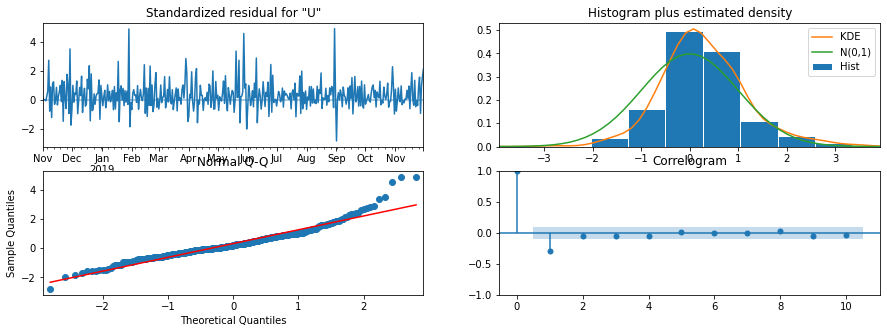

In [35]:
results.plot_diagnostics()
plt.show()

In [36]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test_result = results.predict(start='2019-12-01', end='2020-02-29')
mse = mean_squared_error(test, test_result)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 1114.114493


#### Since this is quiet high value for RMSE the model is not best to predict.

In [37]:
test

,UnitQty
just_date,
2019-12-01,852.8
2019-12-02,2110.0
2019-12-03,1085.0
2019-12-04,855.0
2019-12-05,1221.0
...,...
2020-02-25,2127.0
2020-02-26,1385.0
2020-02-27,919.0


In [38]:
test_result

2019-12-01    2.237312e+03
2019-12-02    1.564239e+03
2019-12-03    1.093654e+03
2019-12-04    7.646388e+02
2019-12-05    5.346049e+02
                  ...     
2020-02-25    9.623071e-11
2020-02-26    6.728067e-11
2020-02-27    4.703995e-11
2020-02-28    3.288845e-11
2020-02-29    2.299429e-11
Freq: D, Name: predicted_mean, Length: 91, dtype: float64

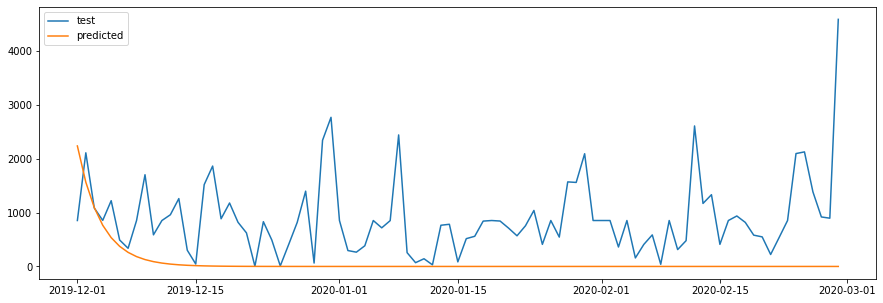

In [39]:
plt.plot(test)
plt.plot(test_result)
plt.legend(['test', 'predicted'])